Dataset:

https://www.kaggle.com/wobotintelligence/face-mask-detection-dataset/download

https://github.com/dsys/nin-imagenet/tree/master/model

https://github.com/opencv/opencv/tree/4.x/samples/dnn/face_detector

### Process of Face Mask Detection with Machine Learning

* Step 1: Extract face data for training.
* Step 2: Train the classifier to classify faces in mask or labels without a mask.
* Step 3: Detect faces while testing data using SSD face detector.
* Step 4: Using the trained classifier, classify the detected faces.

### Import Libraries and datasets

In [1]:
import pandas as pd
import numpy as np
import cv2
import json
import os
import matplotlib.pyplot as plt
import random
import seaborn as sns
from keras.models import Sequential
from keras import backend as K
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from sklearn.model_selection import train_test_split
directory = "/kaggle/input/face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/annotations"
image_directory = "/kaggle/input/face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/images"
df = pd.read_csv("/kaggle/input/face-mask-detection-dataset/train.csv")
df_test = pd.read_csv("/kaggle/input/face-mask-detection-dataset/submission.csv")
df.head()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


,name,x1,x2,y1,y2,classname
0,2756.png,69,126,294,392,face_with_mask
1,2756.png,505,10,723,283,face_with_mask
2,2756.png,75,252,264,390,mask_colorful
3,2756.png,521,136,711,277,mask_colorful
4,6098.jpg,360,85,728,653,face_no_mask


### Creating Helper Functions

I will start this task by creating two helper functions:

In [36]:
cvNet = cv2.dnn.readNetFromCaffe(prototxt='/kaggle/input/deploy1/deploy (1).prototxt',caffeModel='/kaggle/input/caffe-face-detector-opencv-pretrained-model/weights.caffemodel')

def getJSON(filePathandName):
    with open(filePathandName,'r') as f:
        return json.load(f)
def adjust_gamma(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)])
    return cv2.LUT(image.astype(np.uint8), table.astype(np.uint8))

1. The getJSON function retrieves the json file containing the bounding box data in the training dataset.
2. The adjust_gamma function is a non-linear operation used to encode and decode luminance or tristimulus values in video or still image systems. Simply put, it is used to instil a little bit of light into the image. If gamma <1, the image will shift to the darker end of the spectrum and when gamma> 1, there will be more light in the image.

### Data Processing

The next step is now to explore the JSON data provided for the training:

In [4]:
jsonfiles = []
for i in os.listdir(directory):
    jsonfiles.append(getJSON(os.path.join(directory,i)))
jsonfiles[0]

{'FileName': '3758.png',
 'NumOfAnno': 2,
 'Annotations': [{'isProtected': False,
   'ID': 217843115901993120,
   'BoundingBox': [112, 4, 455, 441],
   'classname': 'face_with_mask',
   'Confidence': 1,
   'Attributes': {}},
  {'isProtected': False,
   'ID': 12530598208497002,
   'BoundingBox': [113, 237, 345, 440],
   'classname': 'mask_colorful',
   'Confidence': 1,
   'Attributes': {}}]}

* The Annotations field contains the data of all the faces present in a particular image.
* There are different class names, but the real class names are face_with_mask and face_no_mask.

In [6]:
df = pd.read_csv("/kaggle/input/face-mask-detection-dataset/train.csv")
df.head()

,name,x1,x2,y1,y2,classname
0,2756.png,69,126,294,392,face_with_mask
1,2756.png,505,10,723,283,face_with_mask
2,2756.png,75,252,264,390,mask_colorful
3,2756.png,521,136,711,277,mask_colorful
4,6098.jpg,360,85,728,653,face_no_mask


Using the mask and the non_mask labels, the bounding box data of the json files is extracted. The faces of a particular image are extracted and stored in the data list with its tag for the learning process.

<Axes: ylabel='count'>

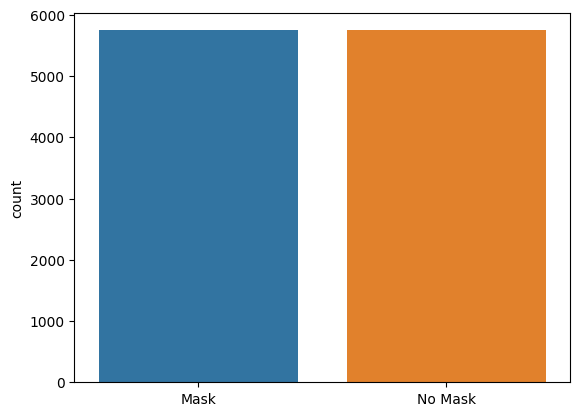

In [20]:
data = []
img_size = 124
mask = ['face_with_mask']
non_mask = ['face_no_mask']
labels = {'mask':0,'without mask':1}
for i in df["name"].unique():
    f = i+".json"
    for j in getJSON(os.path.join(directory,f)).get("Annotations"):
        if j["classname"] in mask:
            x,y,w,h = j["BoundingBox"]
            img = cv2.imread(os.path.join(image_directory,i),1)
            img = img[y:h,x:w]
            img = cv2.resize(img, (img_size,img_size))
            data.append([img,labels["mask"]])
        if j["classname"] in non_mask:
            x,y,w,h = j['BoundingBox']
            img = cv2.imread(os.path.join(image_directory,i),1)
            img = img[y:h,x:w]
            img = cv2.resize(img, (img_size,img_size))
            data.append([img,labels["without mask"]])
random.shuffle(data)

p = []
for face in data:
    if (face[1] == 0):
        p.append("Mask")  # Mask
    else:
        p.append("No Mask")  # No Mask

# Perform one-hot encoding
encoded_data = pd.get_dummies(p)

# Plot the countplot using the encoded data
sns.countplot(data=encoded_data)

In [23]:
X = []
Y = []
for features, labels in data:
    X.append(features)
    Y.append(labels)
    
X = np.array(X)/255.0
X = X.reshape(-1,124,124,3)
Y = np.array(Y)

### Training

In [29]:
from keras.preprocessing.image import ImageDataGenerator

model = Sequential()

model.add(Conv2D(32, (3,3), padding="same", activation='relu', input_shape=(124,124,3)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
xtrain, xval, ytrain, yval = train_test_split(X, Y, train_size=0.8, random_state=0)

# Define the data augmentation parameters
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False
)

# Fit the data generator to the training data
datagen.fit(xtrain)

history = model.fit_generator(datagen.flow(xtrain,ytrain,batch_size=32),
                             steps_per_epoch=xtrain.shape[0]//32,
                             epochs=10,
                             verbose=1,
                             validation_data=(xval,yval))

/tmp/ipykernel_28/103543123.py:37: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(xtrain,ytrain,batch_size=32),


Epoch 1/10


2023-10-07 08:09:35.131373: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


143/143 [==============================] - 40s 187ms/step - loss: 0.4081 - accuracy: 0.8200 - val_loss: 0.2434 - val_accuracy: 0.9000
Epoch 2/10
143/143 [==============================] - 23s 160ms/step - loss: 0.3019 - accuracy: 0.8704 - val_loss: 0.2013 - val_accuracy: 0.9157
Epoch 3/10
143/143 [==============================] - 24s 165ms/step - loss: 0.2711 - accuracy: 0.8936 - val_loss: 0.2005 - val_accuracy: 0.9183
Epoch 4/10
143/143 [==============================] - 23s 160ms/step - loss: 0.2510 - accuracy: 0.9028 - val_loss: 0.1793 - val_accuracy: 0.9304
Epoch 5/10
143/143 [==============================] - 24s 166ms/step - loss: 0.2519 - accuracy: 0.8962 - val_loss: 0.1902 - val_accuracy: 0.9200
Epoch 6/10
143/143 [==============================] - 23s 159ms/step - loss: 0.2612 - accuracy: 0.8953 - val_loss: 0.2078 - val_accuracy: 0.9078
Epoch 7/10
143/143 [==============================] - 24s 164ms/step - loss: 0.2510 - accuracy: 0.9039 - val_loss: 0.1731 - val_accuracy: 0.9

### Testing

The test dataset contains 1698 images and to evaluate the model so I took a handful of images from this dataset as there are no face tags in the dataset:

1/1 [==============================] - 0s 22ms/step


TypeError: imshow() missing 1 required positional argument: 'X'

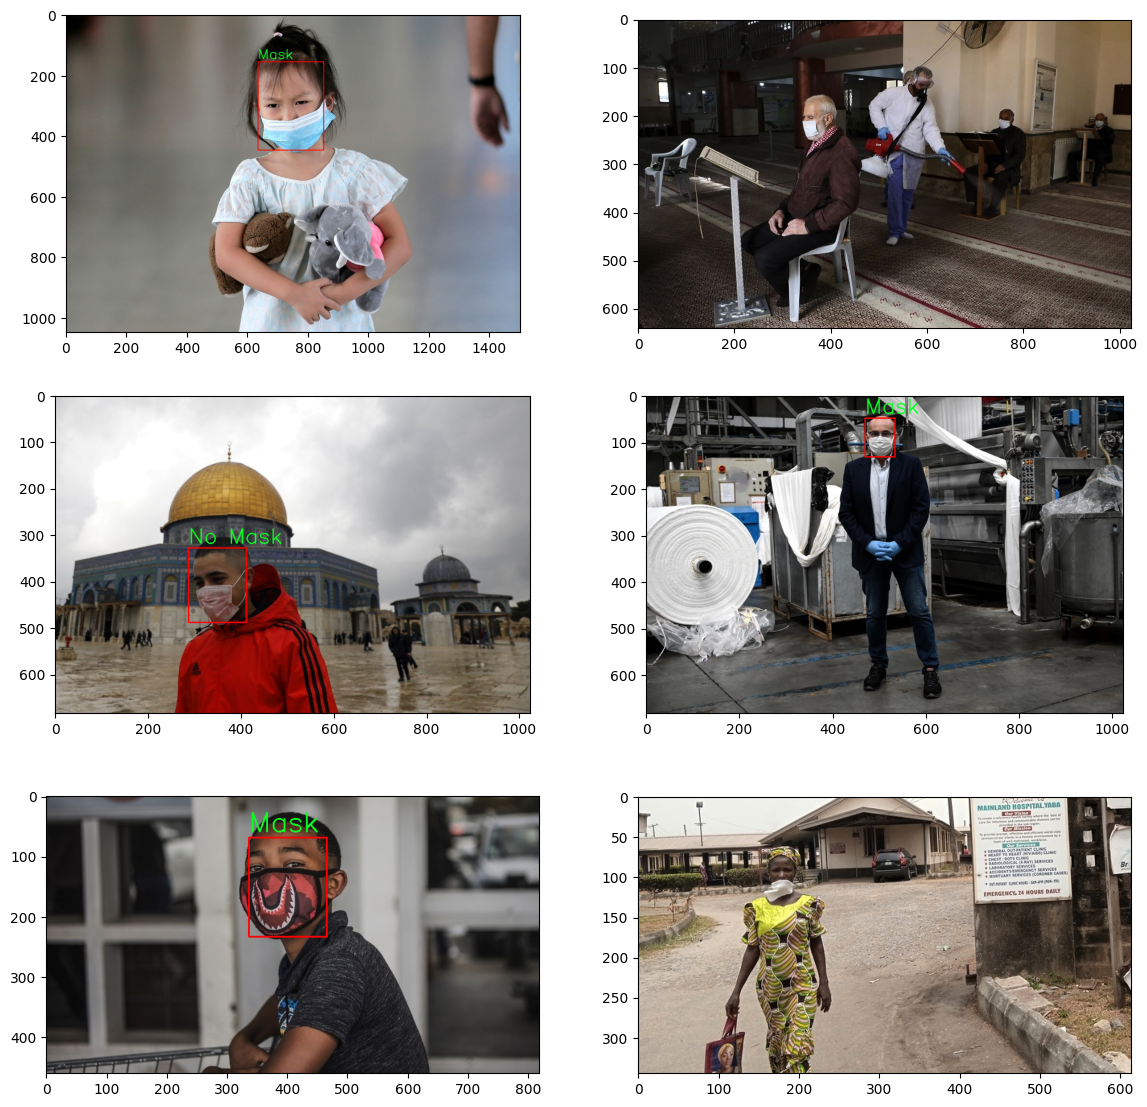

In [38]:
test_images = ['0004.jpg','0014.jpg','0015.jpg','0017.jpg','0018.jpg','0021.jpg']

gamma = 0.9
fig = plt.figure(figsize = (14,14))
rows = 3
cols = 2
axes = []
assign = {'0':'Mask', '1':'No Mask'}
for j, im in enumerate(test_images):
    image = cv2.imread(os.path.join(image_directory,im),1)
    image = adjust_gamma(image, gamma=gamma)
    (h ,w) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300,300)), 1.0, (300,300), (104.0, 177.0, 123.0))
    cvNet.setInput(blob)
    detections = cvNet.forward()
    for i in range(0, detections.shape[2]):
        try:
            box = detections[0,0,i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            frame = image[startY:endY, startX:endX]
            confidence = detections[0,0,i,2]
            if confidence > 0.2:
                im = cv2.resize(frame, (img_size, img_size))
                im = np.array(im)/255.0
                im = im.reshape(1,124, 124, 3)
                result = model.predict(im)
                if result>0.5:
                    label_Y = 1
                else:
                    label_Y = 0
                cv2.rectangle(image, (startX, startY), (endX, endY), (0,0,255),2)
                cv2.putText(image,assign[str(label_Y)] , (startX, startY-10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (36, 255,12), 2)
                
        except:pass
    axes.append(fig.add_subplot(rows, cols, j+1))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.imshow()

Source:

https://thecleverprogrammer.com/2020/11/17/face-mask-detection-with-machine-learning/